In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ghcn import load_daily
from glob import glob
import tqdm
import time
import collections

In [117]:
# Data files
files = sorted(glob('ghcnd_small/*.dly'))

# Load data about stations (we only the station ID and latitude)
# that are in the northern hemisphere (a.k.a. latitude > 0)
north_stations = pd.read_fwf("ghcnd-stations.txt", header=None, usecols=[0, 1])
north_stations.columns = ["station_id", "latitude"]
north_stations = north_stations[north_stations["latitude"] > 0]
north_stations.set_index("station_id", inplace=True)


In [130]:
north_stations['latitude']['BR000062001']

KeyError: 'BR000062001'

In [122]:
# We only care about stations in the northern hemisphere (latitude > 0)
# So go through the list of files, and only load files corresponding to
# stations in the northern hemisphere.
data_all = []
for filename in tqdm.tqdm(files):
    # Get the station name from the filename
    station_name = filename.split(sep='/')[-1][:-4]

    # Get the latitude of the station if it's in the dictionary (if not, it's -1)
    latitude = north_stations.get(station_name, -1)
    
    # Only load this file if the station is in the northern hemisphere (a.k.a. having latitude > 0)
    if latitude < 0:
        continue
    
    # All the data for one station
    df = pd.DataFrame.from_records(load_daily(filename))

    # Extract the temperature data
    filter_ = np.logical_or(df["element"] == "TMIN",
                            df["element"] == "TMAX")
    temperatures = df[filter_]
    
    # Delete unnecessary columns
    temperatures = temperatures.drop(columns=["measurement", "quality", "source"])

    data_all.append(temperatures)

    del filename, station_name, latitude, df, filter_, temperatures
print("Reading files... DONE")

# Combine all the dataframes
data_all = pd.concat(data_all)
print("Dataframe shape:", data_all.shape)

# Delete missing data
data_all = data_all[data_all["value"] != -9999]
print(data_all.groupby(by=["station_id"]).mean())

100%|██████████| 1000/1000 [00:00<00:00, 35788.49it/s]

Reading files... DONE


ValueError: No objects to concatenate

In [81]:


# Load data from each file
dataframes = map(lambda file: pd.DataFrame.from_records(load_daily(file)), files)
dataframes = list(dataframes)

# Combine all the dataframes
df = pd.concat(dataframes)
del dataframes
df

,station_id,year,month,element,day,value,measurement,quality,source
0,AGM00060490,1957,1,TMAX,1,178,,,S
1,AGM00060490,1957,1,TMAX,2,150,,,S
2,AGM00060490,1957,1,TMAX,3,161,,,S
3,AGM00060490,1957,1,TMAX,4,172,,,S
4,AGM00060490,1957,1,TMAX,5,172,,,S
...,...,...,...,...,...,...,...,...,...
15216,ZA000067753,1990,11,PRCP,27,0,,,Q
15217,ZA000067753,1990,11,PRCP,28,0,,,Q
15218,ZA000067753,1990,11,PRCP,29,0,,,Q
15219,ZA000067753,1990,11,PRCP,30,660,,,Q


In [88]:
df.drop(columns=["measurement", "quality", "source"], inplace=True)

In [ ]:
# Extract the temperature data
filter_ = np.logical_or(df["element"] == "TMIN",
                        df["element"] == "TMAX")
temperatures = df.where(filter_).dropna()
# Delete missing data, and unnecessary columns
temperatures = temperatures[temperatures["value"] != -9999]

In [104]:
# Extract the precipitation data
prcp = df.where(df['element'] == 'PRCP').dropna()
# Delete missing data, and unnecessary columns
prcp = prcp[prcp["value"] != -9999]

# For each station and for each year, compute the average temperature across that year
avg_yearly_prcp_per_station = prcp.groupby(by=["station_id", "year"]).mean()["value"].reset_index()

# For each year, compute the average temperature across stations
avg_yearly_prcp = avg_yearly_prcp_per_station.groupby(by=["year"]).mean()["value"].reset_index()


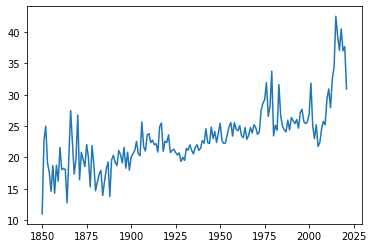

In [110]:
avg_yearly_prcp
plt.plot(avg_yearly_prcp["year"], avg_yearly_prcp["value"])
plt.show()

In [107]:
# Extract the precipitation data
snow = df.where(df['element'] == 'SNOW').dropna()
# Delete missing data, and unnecessary columns
snow = snow[snow["value"] != -9999]

# For each station and for each year, compute the average temperature across that year
avg_yearly_snow_per_station = snow.groupby(by=["station_id", "year"]).mean()["value"].reset_index()

# For each year, compute the average temperature across stations
avg_yearly_snow = avg_yearly_snow_per_station.groupby(by=["year"]).mean()["value"].reset_index()


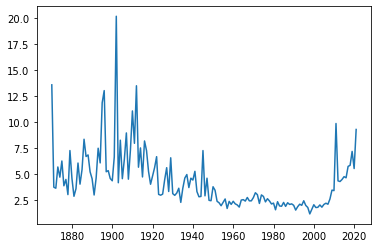

In [109]:
avg_yearly_snow
plt.plot(avg_yearly_snow["year"], avg_yearly_snow["value"])
plt.show()

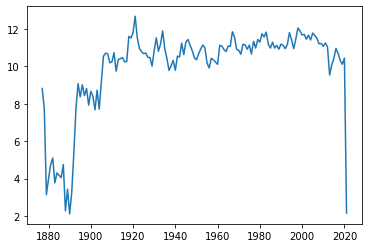

In [87]:

# For each station and for each day, compute the midpoint temperature by
# averaging the min and max temperatures
mid_temps = temperatures.groupby(by=["station_id", "year", "month", "day"]).mean().reset_index()

# For each station and for each year, compute the average temperature across that year
avg_yearly_temps_per_station = mid_temps.groupby(by=["station_id", "year"]).mean()["value"].reset_index()

# For each year, compute the average temperature across stations
avg_yearly_temps = mid_temps.groupby(by=["year"]).mean()["value"].reset_index()

# Plot the result
plt.plot(avg_yearly_temps["year"], avg_yearly_temps["value"]/10)
plt.show()

In [11]:
df = pd.DataFrame(load_daily('ghcnd_small/AGM00060490.dly'))
df.where(df['element'] == 'SNWD').where(df['value'] != -9999.0).dropna()

,station_id,year,month,element,day,value,measurement,quality,source
54029,AGM00060490,2005.0,1.0,SNWD,28.0,20.0,,,S
